<a href="https://colab.research.google.com/github/gabrielborja/python_data_analysis/blob/main/food_habits_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food habits analytics

## Uploading packages and data

In [1]:
#Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (12, 4)})

In [25]:
#Remove previous versions of the uploaded excel file
!rm food_habits.xlsx

In [3]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

Saving food_habits.xlsx to food_habits.xlsx


In [4]:
#Storing dataset in a Pandas Dataframe
import io
df1 = pd.read_excel(io.BytesIO(uploaded1['food_habits.xlsx']))

In [5]:
#Checking the dataframe info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        78 non-null     datetime64[ns]
 1   time        78 non-null     object        
 2   food        78 non-null     object        
 3   large_meal  78 non-null     int64         
 4   ache        78 non-null     int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.2+ KB


In [6]:
#Checking the dataframe head
df1.head(2)

,date,time,food,large_meal,ache
0,2020-07-29,21:05:00,"bread, pepperoni, ham, cheese, ricotta, mustar...",1,1
1,2020-08-02,22:00:00,"pasta, tuna, mayonaise, mustard, carrots, cele...",0,1


##Data Manipulation

In [14]:
#Transforming large meals to list
large_1 = df1[df1['large_meal']==1]['food'].str.cat(sep=', ').split(", ")
large_1[:10]

['bread',
 'pepperoni',
 'ham',
 'cheese',
 'ricotta',
 'mustard',
 'hot_sauce',
 'potato_chips',
 'pizza',
 'tomato_sauce']

In [15]:
#Building dictionary of occurrences for each food
import collections
occurrences = collections.Counter(large_1)
occurrences.get('bread')

11

In [16]:
#Transforming list of foods into series
large_meal_1 = pd.Series(data=large_1)
large_meal_1.tail()

478          bread
479          bread
480    salt_cookie
481       oat_milk
482        granola
dtype: object

In [17]:
#Counting most popular foods
large_meal_1 = large_meal_1.value_counts().reset_index(name='count').rename(columns={'index':'food'})
large_meal_1.head()

,food,count
0,cheese,20
1,onion,14
2,chocolate,14
3,olive_oil,13
4,rice,13


In [18]:
#Transforming ache to list
ache_1 = df1[df1['ache']==1]['food'].str.cat(sep=', ').split(", ")
ache_1[:10]

['bread',
 'pepperoni',
 'ham',
 'cheese',
 'ricotta',
 'mustard',
 'hot_sauce',
 'potato_chips',
 'pizza',
 'tomato_sauce']

In [19]:
#Building dictionary of occurrences for each food
ache_occurrences = collections.Counter(ache_1)
ache_occurrences.get('bread')

15

In [20]:
#Transforming list of foods into series
ache_meal_1 = pd.Series(data=ache_1)
ache_meal_1.tail()

589        lettuce
590    red_paprika
591        sausage
592          pesto
593    kebap_sauce
dtype: object

In [21]:
#Counting most popular foods
ache_meal_1 = ache_meal_1.value_counts().reset_index(name='count').rename(columns={'index':'food'})
ache_meal_1.head()

,food,count
0,cheese,25
1,chocolate,20
2,rice,19
3,olive_oil,18
4,onion,17


##Data Visualization

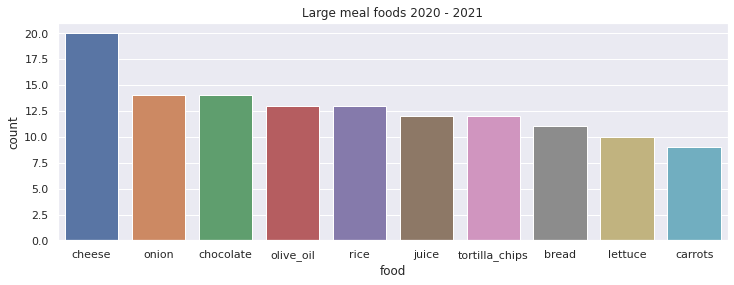

In [24]:
#Plotting the top 10 large meals
sns.barplot(x='food', y='count', data=large_meal_1[:10])
plt.title('Large meal foods 2020 - 2021')
plt.show()

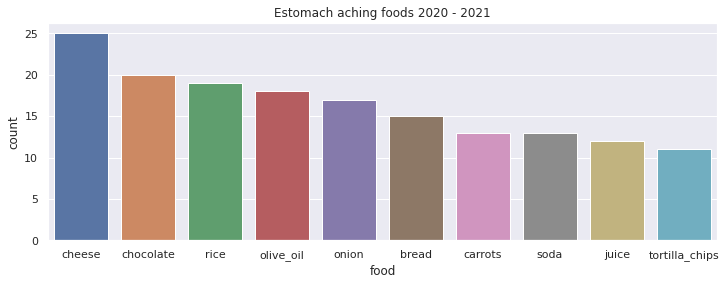

In [25]:
#Plotting the top 10 estomach aching meals
sns.barplot(x='food', y='count', data=ache_meal_1[:10])
plt.title('Estomach aching foods 2020 - 2021')
plt.show()

In [ ]:
#Exporting to excel into local disk
from google.colab import files
df1.to_excel('food_habits.xlsx', index=False) #==> Excluding index from file
files.download('food_habits.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>